In [2]:
import json
from collections import defaultdict
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def load_entries_to_df(file_path):
    entries = []
    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)
            if data.get("type") == "entry":
                instance_name = data.get("entry_name")
                instance = data.get("instance", {})
                features = instance.get("features", {})
                original = instance.get("original_outcome")
                predicted = instance.get("predicted_outcome")

                entry_dict = {
                    "Instance_Name": instance_name,
                    "Original_Outcome": original,
                    "Predicted_Outcome": predicted,
                    **features
                }
                entries.append(entry_dict)
    df = pd.DataFrame(entries)
    return df


def load_and_group_rules(file_path):
    grouped_rules = defaultdict(lambda: defaultdict(list))
    
    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)
            if data.get("type") == "rule":
                premises = data["rule"]["premises"]
                premises_str = " AND ".join(f'{p["attr"]} {p["op"]} {p["val"]}' for p in premises)
                consequence = data["rule"]["consequence"]
                consequence_str = f'{consequence["attr"]} {consequence["op"]} {consequence["val"]}'
                rule_str = f'IF {premises_str} THEN {consequence_str}'
                
                metrics = data.get("metrics", {})
                rule_dict = {
                    "Premises": premises,
                    "Rule_ID": None,  # You can fill this later if needed
                    "Rule": rule_str,
                    "Cov": round(metrics.get("coverage", 0), 5),
                    "Cov_class": round(metrics.get("local_class_coverage", 0), 5),
                    "Pre": round(metrics.get("precision", 0), 5),
                    "Len": metrics.get("rule_length", 0),
                    "Reject": metrics.get("rejected", 0),
                    "Elapsed_time": round(metrics.get("elapsed_time", 0), 5),
                    "Iter_Limit": data.get("at_limit", False)
                }
                
                instance_name = data.get("entry_name")
                explainer = data.get("explainer")
                grouped_rules[instance_name][explainer].append(rule_dict)
    
    return grouped_rules

def grouped_rules_to_df(grouped_rules):
    rows = []
    for instance_name, explainers_dict in grouped_rules.items():
        for explainer, rules_list in explainers_dict.items():
           for i, rule_dict in enumerate(rules_list, start=1):
                row = {
                    "Instance_Name": instance_name,
                    "Explainer": explainer,
                }
                row.update(rule_dict)
                row["Rule_ID"] = f"{explainer}{i}"
                rows.append(row)
    return pd.DataFrame(rows)


def filter_non_dominated(df, cov_col='Cov', pre_col='Pre'):
    non_dominated_indices = []
    for i, row_i in df.iterrows():
        dominated = False
        for j, row_j in df.iterrows():
            if i != j:
                if (row_j[cov_col] >= row_i[cov_col] and
                    row_j[pre_col] >= row_i[pre_col] and
                    (row_j[cov_col] > row_i[cov_col] or row_j[pre_col] > row_i[pre_col])):
                    dominated = True
                    break
        if not dominated:
            non_dominated_indices.append(i)

    return df.loc[non_dominated_indices].reset_index(drop=True)


def filter_non_dominated_3d(df, cov_col='Cov_class', pre_col='Pre', len_col='Len'):
    # convert to numpy for speed
    data = df[[cov_col, pre_col, len_col]].to_numpy()

    non_dominated_mask = []
    for i, candidate in enumerate(data):
        dominated = False
        for j, other in enumerate(data):
            if i == j:
                continue
            # check if 'other' dominates 'candidate':
            # other is better or equal in all objectives AND strictly better in at least one
            # for cov_col and pre_col (to maximize): other >= candidate
            # for len_col (to minimize): other <= candidate
            if (other[0] >= candidate[0] and
                other[1] >= candidate[1] and
                other[2] <= candidate[2] and
                (other[0] > candidate[0] or other[1] > candidate[1] or other[2] < candidate[2])):
                dominated = True
                break
        non_dominated_mask.append(not dominated)

    return df.loc[non_dominated_mask]

def plot_non_dominated_rules(non_dominated_rules, instance_name):
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=non_dominated_rules,
        x='Cov', 
        y='Pre',
        hue='Explainer',
        style='Explainer',
        palette='tab10',
        s=100
    )
    
    plt.title(f"Non-dominated Rules for Instance {instance_name} (Coverage ↑, Precision ↑)")
    plt.xlabel("Coverage")
    plt.ylabel("Precision")
    plt.legend(title='Explainer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def count_unique_attributes_from_rules(df_rules):
    attr_counter = Counter()

    for premises in df_rules['Premises']:
        seen_attrs = set()
        for cond in premises:
            attr = cond['attr']
            seen_attrs.add(attr)
        for attr in seen_attrs:
            attr_counter[attr] += 1  # Count only once per rule
    return dict(attr_counter)

def build_attr_usage_df(df_rules):
    rows = []
    for explainer, group in df_rules.groupby('Explainer'):
        attr_counts = count_unique_attributes_from_rules(group)
        for attr, count in attr_counts.items():
            rows.append({"Explainer": explainer, "Feature": attr, "Count": count})
    return pd.DataFrame(rows)

def plot_feature_usage_heatmap(df: pd.DataFrame, 
                               feature_col: str, 
                               explainer_col: str, 
                               count_col: str,
                               all_features: list,
                               vmax: float = None,
                               figsize=(10,8),
                               cmap='YlOrRd'):

    if df.empty:
        print("Empty dataframe: nothing to plot.")
        return
    # pivot table with counts: rows=features, columns=explainers
    heatmap_data = df.pivot_table(index=feature_col, columns=explainer_col, values=count_col, fill_value=0)
    heatmap_data = heatmap_data.reindex(all_features, fill_value=0)

    explainers_with_features = heatmap_data.columns.tolist()
    top_feature_names = heatmap_data.index.tolist()
    actual_max_count = heatmap_data.values.max()
    theoretical_max = vmax if vmax is not None else actual_max_count

    if heatmap_data is not None and theoretical_max > 0:
        plt.figure(figsize=figsize)
        plt.imshow(heatmap_data, cmap=cmap, vmax=theoretical_max, aspect='auto')
        plt.colorbar(label='Rule Count')
        plt.xticks(ticks=range(len(explainers_with_features)), labels=explainers_with_features, rotation=45, ha='right')
        plt.yticks(ticks=range(len(top_feature_names)), labels=top_feature_names)
        plt.title(f'Feature Usage Across Explainers\n(Scale: 0 to {theoretical_max}, Actual max: {actual_max_count})')
        plt.tight_layout()
        plt.show()
    else:
        print("No data to display or vmax <= 0.")

def plot_rules_comparison(all_rules, filtered_rules, instance_name):
    plt.figure(figsize=(8,6))
    
    # palette for explainers across both datasets
    explainers = sorted(all_rules['Explainer'].unique())
    palette = sns.color_palette('tab10', n_colors=len(explainers))
    explainer_palette = dict(zip(explainers, palette))
    
    # all rules - circles
    sns.scatterplot(
        data=all_rules,
        x='Cov',
        y='Pre',
        hue='Explainer',
        palette=explainer_palette,
        s=60,
        alpha=0.5,
        marker='o'
    )
    
    # filtered rules - X markers with edgecolors
    sns.scatterplot(
        data=filtered_rules,
        x='Cov',
        y='Pre',
        hue='Explainer',
        palette=explainer_palette,
        s=120,
        marker='X',
        edgecolor='black'
    )
    
    # lines connecting filtered rules sorted by Coverage
    filtered_sorted = filtered_rules.sort_values(by='Cov')
    plt.plot(filtered_sorted['Cov'], filtered_sorted['Pre'], color='gray', linestyle='--', linewidth=1)
    
    plt.title(f"Rules for Instance {instance_name} (Coverage ↑, Precision ↑)")
    plt.xlabel("Coverage")
    plt.ylabel("Precision")
    
    handles, labels = plt.gca().get_legend_handles_labels()
    
    by_label = dict(zip(labels, handles))
    
    plt.legend(by_label.values(), by_label.keys(), title='Explainer', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def summarize_explainer_metrics_with_global_average(explainer_dict):
    summary = {}
    all_rows = []

    for explainer, metrics_list in explainer_dict.items():
        df = pd.DataFrame(metrics_list)
        summary[explainer] = df.mean()
        all_rows.append(df)

    df_summary = pd.DataFrame(summary).T

    global_df = pd.concat(all_rows, ignore_index=True)
    df_summary.loc["Global_Average"] = global_df.mean()

    return df_summary

In [3]:
from IPython.display import display, Markdown
pd.set_option('display.max_colwidth', None) 

def analyze_results(rules_log, entries_log, min_cov = 0.1, min_cov_class = 0.1, min_pre = 0.1):
    path = "./experiments_log/"
    rules_grouped = load_and_group_rules(path+rules_log)
    df_instances = load_entries_to_df(path+entries_log)
    df_rules = grouped_rules_to_df(rules_grouped)
    instance_names = df_rules['Instance_Name'].unique()
    filtered_counts = defaultdict(list)
    non_dom1_by_explainer = defaultdict(list)
    non_dom2_by_explainer = defaultdict(list)
    filtered_counts_by_explainer = {
        'Correct Prediction': defaultdict(list),
        'Threshold Filter': defaultdict(list),
        'Non-dominated 1': defaultdict(list),
        'Non-dominated 2': defaultdict(list),
    }
    agg_all_dom1 = []
    agg_all_dom2 = []
    
    for i, instance_name in enumerate(instance_names, start=1):
        max_rules = df_rules[df_rules['Instance_Name'] == instance_name].groupby('Explainer').size().max()
        orig = df_instances.loc[df_instances['Instance_Name'] == instance_name, "Original_Outcome"].iloc[0]
        pred = df_instances.loc[df_instances['Instance_Name'] == instance_name, "Predicted_Outcome"].iloc[0]
        display(Markdown(f"## Instance {instance_name} (Original: {orig} , Predicted: {pred})"))
        instance = df_instances[df_instances['Instance_Name'] == instance_name]
        exclude_cols = ['Instance_Name', 'Original_Outcome', 'Predicted_Outcome']
        attributes = [col for col in instance.columns if col not in exclude_cols]
        display(instance.drop(columns=['Instance_Name', 'Original_Outcome', 'Predicted_Outcome']).T.rename(columns={df_instances[df_instances['Instance_Name'] == instance_name].index[0]: 'Value'}))
        
        display(Markdown(f"### Rules for Instance {instance_name}"))
        display(df_rules[df_rules['Instance_Name'] == instance_name].drop(columns=["Premises"]).reset_index(drop=True))
       
        display(Markdown(f"### Rules for Instance {instance_name}, Correct Prediction"))
        original_outcome = df_instances.loc[df_instances['Instance_Name'] == instance_name, 'Original_Outcome'].values[0]
        correct_pred_rules = df_rules[
        (df_rules['Instance_Name'] == instance_name) &
        (df_rules['Rule'].str.contains(f'class = {original_outcome}', na=False))
        ]
        display(correct_pred_rules.drop(columns=["Premises"]).reset_index(drop=True))

        display(Markdown(f"### Rules for Instance {instance_name}, Min_treshold (Cov {min_cov}, Cov_class {min_cov_class}, Pre {min_pre})"))
        tresholded_rules = correct_pred_rules[
        (correct_pred_rules['Cov'] >= min_cov) &
        (correct_pred_rules['Cov_class'] >= min_cov_class) &
        (correct_pred_rules['Pre'] >= min_pre)
        ]
        display(tresholded_rules.drop(columns=["Premises"]).reset_index(drop=True))
    
    
        display(Markdown(f"### Rules for Instance {instance_name}, Non-dominated (Cov↑, Pre↑)"))
        non_dominated_rules1 = filter_non_dominated(tresholded_rules)
        display(non_dominated_rules1.drop(columns=["Premises"]).reset_index(drop=True))
        plot_non_dominated_rules(non_dominated_rules1, instance_name)
        plot_rules_comparison(all_rules=df_rules[df_rules['Instance_Name'] == instance_name],
                          filtered_rules=non_dominated_rules1,
                          instance_name=instance_name)
        agg_df = build_attr_usage_df(non_dominated_rules1)
        agg_all_dom1.append(agg_df)
        plot_feature_usage_heatmap(agg_df, feature_col="Feature", explainer_col="Explainer", count_col="Count", all_features=attributes, vmax = max_rules)
    
        display(Markdown(f"### Rules for Instance {instance_name}, Non-dominated (Cov_class↑, Pre↑, Len↓)"))
        non_dominated_rules2 = filter_non_dominated_3d(tresholded_rules)
        display(non_dominated_rules2.drop(columns=["Premises"]).reset_index(drop=True))
        agg_df = build_attr_usage_df(non_dominated_rules2)
        agg_all_dom2.append(agg_df)
        plot_feature_usage_heatmap(agg_df, feature_col="Feature", explainer_col="Explainer", count_col="Count", all_features=attributes, vmax = max_rules)
    
        all_rules_count = len(df_rules[df_rules['Instance_Name'] == instance_name])
        correct_pred_count = len(correct_pred_rules)
        tresholded_count = len(tresholded_rules)
        non_dom1_count = len(non_dominated_rules1)
        non_dom2_count = len(non_dominated_rules2)
        
        # filtered counts
        filtered_counts['Correct Prediction'].append(all_rules_count - correct_pred_count)
        filtered_counts['Threshold Filter'].append(correct_pred_count - tresholded_count)
        filtered_counts['Non-dominated 1'].append(tresholded_count - non_dom1_count)
        filtered_counts['Non-dominated 2'].append(tresholded_count - non_dom2_count)
    
        original_rules_instance = df_rules[df_rules['Instance_Name'] == instance_name]
        orig_counts = original_rules_instance['Explainer'].value_counts()
        correct_pred_counts = correct_pred_rules['Explainer'].value_counts()
        filtered_per_explainer_cp = (orig_counts - correct_pred_counts).fillna(orig_counts).astype(int)
        for explainer, count in filtered_per_explainer_cp.items():
            filtered_counts_by_explainer['Correct Prediction'][explainer].append(count)
        tresholded_counts = tresholded_rules['Explainer'].value_counts()
        filtered_per_explainer_thresh = (correct_pred_counts - tresholded_counts).fillna(correct_pred_counts).astype(int)
        for explainer, count in filtered_per_explainer_thresh.items():
            filtered_counts_by_explainer['Threshold Filter'][explainer].append(count)
        non_dom1_counts = non_dominated_rules1['Explainer'].value_counts()
        filtered_per_explainer_non_dom1 = (tresholded_counts - non_dom1_counts).fillna(tresholded_counts).astype(int)
        for explainer, count in filtered_per_explainer_non_dom1.items():
            filtered_counts_by_explainer['Non-dominated 1'][explainer].append(count)
        non_dominated_rules2 = filter_non_dominated_3d(tresholded_rules)
        non_dom2_counts = non_dominated_rules2['Explainer'].value_counts()
        filtered_per_explainer_non_dom2 = (tresholded_counts - non_dom2_counts).fillna(tresholded_counts).astype(int)
        for explainer, count in filtered_per_explainer_non_dom2.items():
            filtered_counts_by_explainer['Non-dominated 2'][explainer].append(count)
    
        
        if not non_dominated_rules1.empty:
            for explainer, group in non_dominated_rules1.groupby("Explainer"):
                non_dom1_by_explainer[explainer].append(
                    group[['Pre', 'Cov', 'Cov_class', 'Len', 'Reject', 'Elapsed_time']].mean()
                )
    
        if not non_dominated_rules2.empty:
            for explainer, group in non_dominated_rules2.groupby("Explainer"):
                non_dom2_by_explainer[explainer].append(
                    group[['Pre', 'Cov', 'Cov_class', 'Len', 'Reject', 'Elapsed_time']].mean()
                )
        
    
    # average filtered rules per stage
    display(Markdown("### Average Number of Filtered Rules at Each Step"))
    filtration_summary = pd.DataFrame({stage: pd.Series(values).mean() for stage, values in filtered_counts.items()}, index=["Avg Filtered"]).T
    # display(filtration_summary)
    step_avg_dfs = {}
    for step, explainer_dict in filtered_counts_by_explainer.items():
        df = pd.DataFrame({expl: pd.Series(counts) for expl, counts in explainer_dict.items()})
        step_avg_dfs[step] = df.mean().rename(step)  # Series with index=explainer, values=avg filtered
    
    combined_df = pd.concat(step_avg_dfs.values(), axis=1).fillna(0)
    combined_df.index.name = 'Explainer'
    combined_df.columns = [f"Avg Filtered ({col})" for col in combined_df.columns]
    
    mapping = {
        'Correct Prediction': 'Avg Filtered (Correct Prediction)',
        'Threshold Filter': 'Avg Filtered (Threshold Filter)',
        'Non-dominated 1': 'Avg Filtered (Non-dominated 1)',
        'Non-dominated 2': 'Avg Filtered (Non-dominated 2)'
    }
    new_row = {}
    for step, col_name in mapping.items():
        new_row[col_name] = filtration_summary.loc[step, 'Avg Filtered']
    
    combined_df.loc['Overall Average'] = pd.Series(new_row)
    display(combined_df)
    
    # average metrics for non-dominated rules
    display(Markdown("### Average Metrics for Non-Dominated Rules (Cov↑, Pre↑)"))
    explainer_summary1 = summarize_explainer_metrics_with_global_average(non_dom1_by_explainer)
    display(explainer_summary1)

    display(Markdown("### Average Metrics for Non-Dominated Rules (Cov_class↑, Pre↑, Len↓)"))
    explainer_summary2 = summarize_explainer_metrics_with_global_average(non_dom2_by_explainer)
    display(explainer_summary2)

    agg_all_dom1_df = pd.concat(agg_all_dom1).groupby(['Feature', 'Explainer']).sum().reset_index()
    agg_all_dom2_df = pd.concat(agg_all_dom2).groupby(['Feature', 'Explainer']).sum().reset_index()

    all_features = [col for col in df_instances.columns if col not in ['Instance_Name', 'Original_Outcome', 'Predicted_Outcome']]
    
    display(Markdown("## Overall Heatmap – Non-dominated Rules (Cov↑, Pre↑)"))
    plot_feature_usage_heatmap(agg_all_dom1_df, feature_col="Feature", explainer_col="Explainer", count_col="Count", all_features=all_features, vmax = max_rules*len(instance_names))
    
    display(Markdown("## Overall Heatmap – Non-dominated Rules (Cov_class↑, Pre↑, Len↓)"))
    plot_feature_usage_heatmap(agg_all_dom2_df, feature_col="Feature", explainer_col="Explainer", count_col="Count", all_features=all_features, vmax = max_rules*len(instance_names))

## Instance 844 (Original: good , Predicted: good)

,Value
checking_status,no checking
duration,18.0
credit_history,existing paid
purpose,furniture/equipment
credit_amount,3422.0
savings_status,less 100
employment,greater 7 years
installment_commitment,4.0
personal_status,male single
other_parties,none


### Rules for Instance 844

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,844,ANCHOR,ANCHOR1,IF checking_status = no checking THEN class = good,0.29490,0.49796,0.84429,1,0,4.13354,False
1,844,ANCHOR,ANCHOR2,IF age > 26.72 AND checking_status = no checking THEN class = good,0.24592,0.41837,0.85062,2,1,10.98420,False
2,844,ANCHOR,ANCHOR3,IF checking_status = no checking AND duration <= 25.78 THEN class = good,0.23163,0.40816,0.88106,2,1,10.65441,False
3,844,ANCHOR,ANCHOR4,IF checking_status = no checking AND residence_since <= 4.0 THEN class = good,0.29490,0.49796,0.84429,2,0,3.10165,False
4,844,ANCHOR,ANCHOR5,IF checking_status = no checking AND housing = own THEN class = good,0.23163,0.39388,0.85022,2,5,29.88871,False
5,844,LORE,LORE1,IF age > 46.77991 AND duration <= 18.0 AND savings_status = less 100 THEN class = good,0.05000,0.05714,0.57143,3,0,65.01539,False
6,844,LORE,LORE2,IF checking_status = no checking AND housing = own AND installment_commitment > 3.0 THEN class = bad,0.11633,0.03673,0.15789,3,0,110.07842,False
7,844,LORE,LORE3,IF checking_status = no checking AND duration <= 23.488716 AND housing = own AND job = skilled THEN class = bad,0.09082,0.01633,0.08989,4,0,167.97627,False
8,844,LORE,LORE4,IF age <= 47.0 AND checking_status = no checking AND duration > 17.815815 AND existing_credits > 1.0 AND housing = own AND installment_commitment > 3.0 AND other_payment_plans = bank AND purpose = furniture/equipment AND savings_status = less 100 THEN class = bad,0.00000,0.00000,0.00000,9,0,126.92614,False
9,844,LORE,LORE5,IF age > 46.339264 AND checking_status = no checking AND housing = own AND installment_commitment > 3.0 THEN class = bad,0.02041,0.00408,0.10000,4,0,78.44114,False


### Rules for Instance 844, Correct Prediction

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,844,ANCHOR,ANCHOR1,IF checking_status = no checking THEN class = good,0.29490,0.49796,0.84429,1,0,4.13354,False
1,844,ANCHOR,ANCHOR2,IF age > 26.72 AND checking_status = no checking THEN class = good,0.24592,0.41837,0.85062,2,1,10.98420,False
2,844,ANCHOR,ANCHOR3,IF checking_status = no checking AND duration <= 25.78 THEN class = good,0.23163,0.40816,0.88106,2,1,10.65441,False
3,844,ANCHOR,ANCHOR4,IF checking_status = no checking AND residence_since <= 4.0 THEN class = good,0.29490,0.49796,0.84429,2,0,3.10165,False
4,844,ANCHOR,ANCHOR5,IF checking_status = no checking AND housing = own THEN class = good,0.23163,0.39388,0.85022,2,5,29.88871,False
5,844,LORE,LORE1,IF age > 46.77991 AND duration <= 18.0 AND savings_status = less 100 THEN class = good,0.05000,0.05714,0.57143,3,0,65.01539,False
6,844,LORE_SA,LORE_SA1,IF checking_status = no checking AND credit_amount <= 16227.375 AND employment != unemployed AND housing = own AND job != high qualif/self emp/mgmt THEN class = good,0.19490,0.33673,0.86387,5,0,13.00305,False
7,844,LORE_SA,LORE_SA2,IF checking_status = no checking AND housing = own AND job != unskilled resident AND purpose != business AND residence_since > 1.5854892134666443 THEN class = good,0.15714,0.27755,0.88312,5,0,12.93221,False
8,844,LORE_SA,LORE_SA3,IF checking_status = no checking AND credit_history != delayed previously AND housing = own AND num_dependents > 1.8686306476593018 AND property_magnitude != car THEN class = good,0.02143,0.03878,0.90476,5,0,12.46233,False
9,844,LORE_SA,LORE_SA4,IF checking_status = no checking AND housing = own AND installment_commitment > 2.742795467376709 THEN class = good,0.15612,0.26735,0.85621,3,0,11.38832,False


### Rules for Instance 844, Min_treshold (Cov 0.01, Cov_class 0.01, Pre 0.01)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,844,ANCHOR,ANCHOR1,IF checking_status = no checking THEN class = good,0.29490,0.49796,0.84429,1,0,4.13354,False
1,844,ANCHOR,ANCHOR2,IF age > 26.72 AND checking_status = no checking THEN class = good,0.24592,0.41837,0.85062,2,1,10.98420,False
2,844,ANCHOR,ANCHOR3,IF checking_status = no checking AND duration <= 25.78 THEN class = good,0.23163,0.40816,0.88106,2,1,10.65441,False
3,844,ANCHOR,ANCHOR4,IF checking_status = no checking AND residence_since <= 4.0 THEN class = good,0.29490,0.49796,0.84429,2,0,3.10165,False
4,844,ANCHOR,ANCHOR5,IF checking_status = no checking AND housing = own THEN class = good,0.23163,0.39388,0.85022,2,5,29.88871,False
5,844,LORE,LORE1,IF age > 46.77991 AND duration <= 18.0 AND savings_status = less 100 THEN class = good,0.05000,0.05714,0.57143,3,0,65.01539,False
6,844,LORE_SA,LORE_SA1,IF checking_status = no checking AND credit_amount <= 16227.375 AND employment != unemployed AND housing = own AND job != high qualif/self emp/mgmt THEN class = good,0.19490,0.33673,0.86387,5,0,13.00305,False
7,844,LORE_SA,LORE_SA2,IF checking_status = no checking AND housing = own AND job != unskilled resident AND purpose != business AND residence_since > 1.5854892134666443 THEN class = good,0.15714,0.27755,0.88312,5,0,12.93221,False
8,844,LORE_SA,LORE_SA3,IF checking_status = no checking AND credit_history != delayed previously AND housing = own AND num_dependents > 1.8686306476593018 AND property_magnitude != car THEN class = good,0.02143,0.03878,0.90476,5,0,12.46233,False
9,844,LORE_SA,LORE_SA4,IF checking_status = no checking AND housing = own AND installment_commitment > 2.742795467376709 THEN class = good,0.15612,0.26735,0.85621,3,0,11.38832,False


### Rules for Instance 844, Non-dominated (Cov↑, Pre↑)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,844,ANCHOR,ANCHOR1,IF checking_status = no checking THEN class = good,0.29490,0.49796,0.84429,1,0,4.13354,False
1,844,ANCHOR,ANCHOR2,IF age > 26.72 AND checking_status = no checking THEN class = good,0.24592,0.41837,0.85062,2,1,10.98420,False
2,844,ANCHOR,ANCHOR3,IF checking_status = no checking AND duration <= 25.78 THEN class = good,0.23163,0.40816,0.88106,2,1,10.65441,False
3,844,ANCHOR,ANCHOR4,IF checking_status = no checking AND residence_since <= 4.0 THEN class = good,0.29490,0.49796,0.84429,2,0,3.10165,False
4,844,LORE_SA,LORE_SA2,IF checking_status = no checking AND housing = own AND job != unskilled resident AND purpose != business AND residence_since > 1.5854892134666443 THEN class = good,0.15714,0.27755,0.88312,5,0,12.93221,False
5,844,LORE_SA,LORE_SA3,IF checking_status = no checking AND credit_history != delayed previously AND housing = own AND num_dependents > 1.8686306476593018 AND property_magnitude != car THEN class = good,0.02143,0.03878,0.90476,5,0,12.46233,False


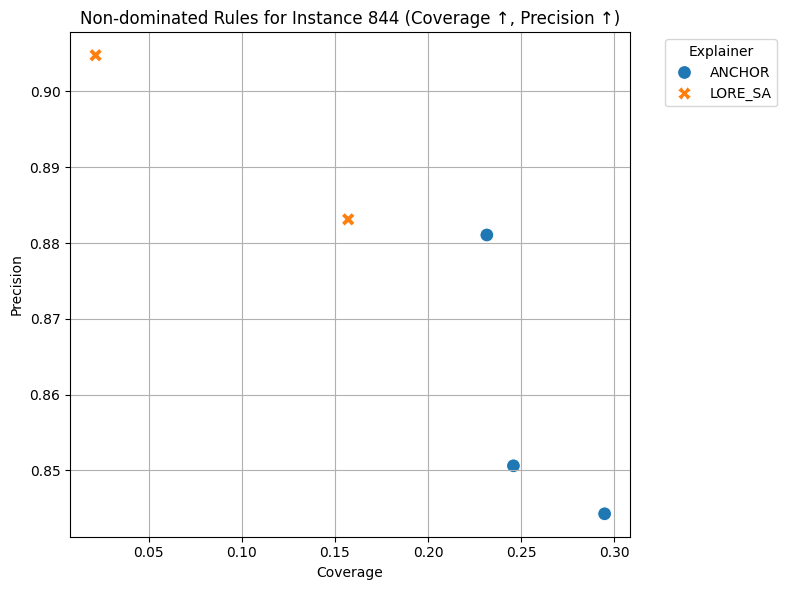

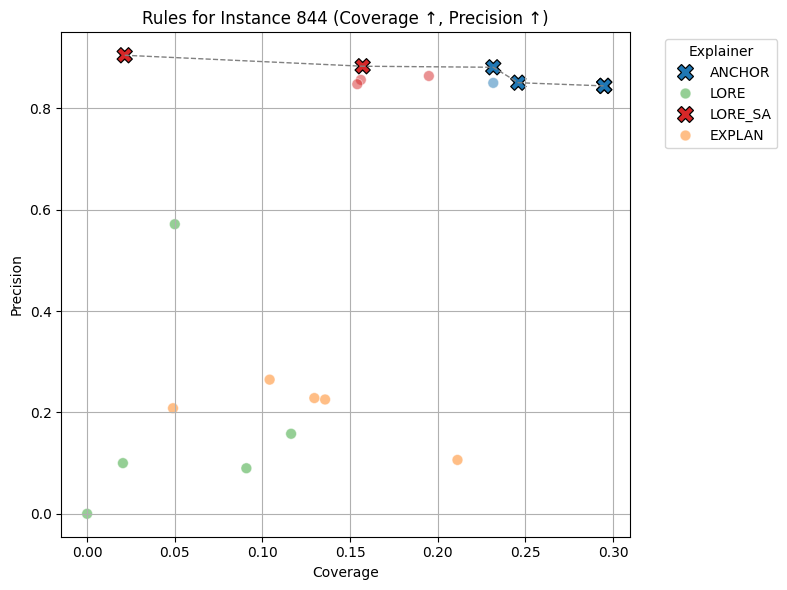

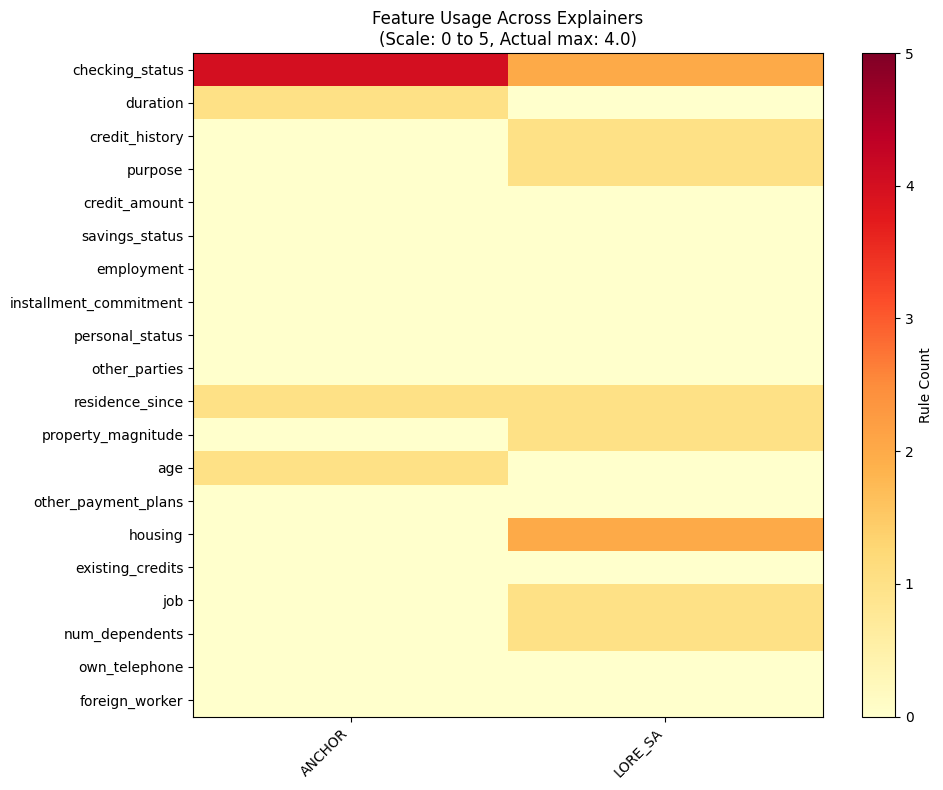

### Rules for Instance 844, Non-dominated (Cov_class↑, Pre↑, Len↓)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,844,ANCHOR,ANCHOR1,IF checking_status = no checking THEN class = good,0.29490,0.49796,0.84429,1,0,4.13354,False
1,844,ANCHOR,ANCHOR2,IF age > 26.72 AND checking_status = no checking THEN class = good,0.24592,0.41837,0.85062,2,1,10.98420,False
2,844,ANCHOR,ANCHOR3,IF checking_status = no checking AND duration <= 25.78 THEN class = good,0.23163,0.40816,0.88106,2,1,10.65441,False
3,844,LORE_SA,LORE_SA2,IF checking_status = no checking AND housing = own AND job != unskilled resident AND purpose != business AND residence_since > 1.5854892134666443 THEN class = good,0.15714,0.27755,0.88312,5,0,12.93221,False
4,844,LORE_SA,LORE_SA3,IF checking_status = no checking AND credit_history != delayed previously AND housing = own AND num_dependents > 1.8686306476593018 AND property_magnitude != car THEN class = good,0.02143,0.03878,0.90476,5,0,12.46233,False


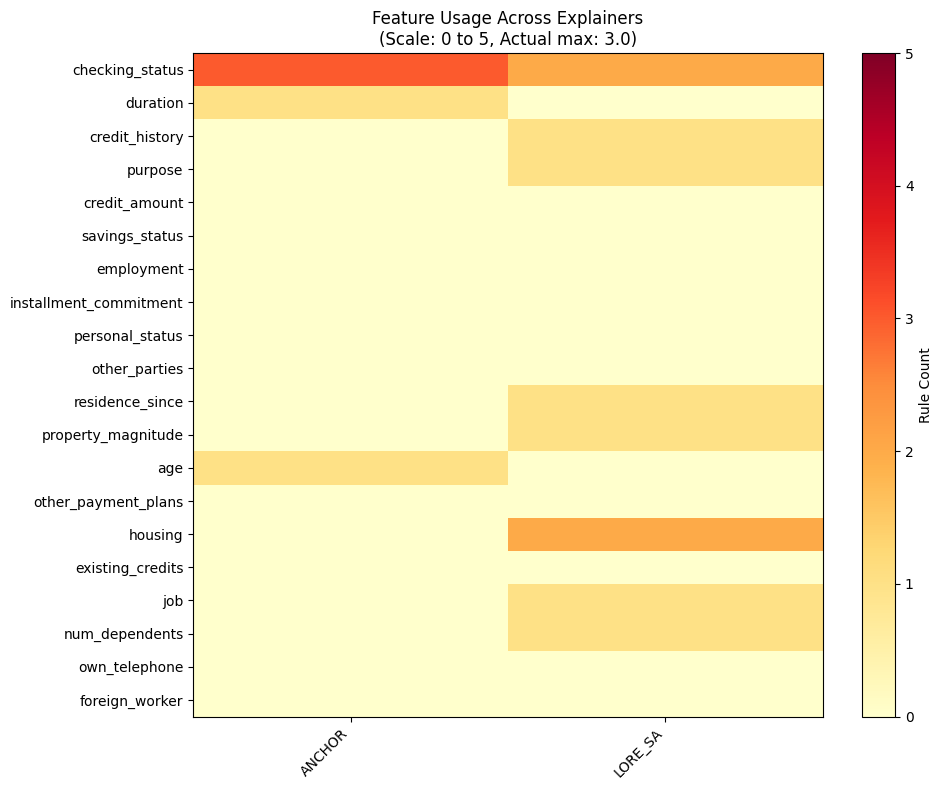

## Instance 480 (Original: good , Predicted: good)

,Value
checking_status,between 0 and 200
duration,12.0
credit_history,critical/other existing credit
purpose,radio/tv
credit_amount,3573.0
savings_status,less 100
employment,between 1 and 4 years
installment_commitment,1.0
personal_status,female div/dep/mar
other_parties,none


### Rules for Instance 480

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,480,ANCHOR,ANCHOR1,IF credit_history = critical/other existing credit AND duration <= 12.0 AND property_magnitude = real estate THEN class = good,0.03878,0.07347,0.94737,3,0,28.28518,False
1,480,ANCHOR,ANCHOR2,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 18.0 AND property_magnitude = real estate THEN class = good,0.04694,0.07755,0.82609,4,0,24.53378,False
2,480,ANCHOR,ANCHOR3,IF credit_history = critical/other existing credit AND duration <= 12.0 AND installment_commitment <= 2.0 THEN class = good,0.03878,0.07143,0.92105,3,0,40.22697,False
3,480,ANCHOR,ANCHOR4,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 12.0 THEN class = good,0.08265,0.14694,0.88889,3,0,32.39391,False
4,480,ANCHOR,ANCHOR5,IF credit_history = critical/other existing credit AND duration <= 12.0 AND installment_commitment <= 3.24 THEN class = good,0.05000,0.09184,0.91837,3,0,35.27383,False
5,480,LORE,LORE1,IF duration <= 12.0 THEN class = bad,0.30408,0.18776,0.30872,1,0,352.43460,False
6,480,LORE,LORE2,IF duration <= 13.410599 THEN class = bad,0.31122,0.20000,0.32131,1,0,396.59238,False
7,480,LORE,LORE3,IF duration <= 12.811666 THEN class = bad,0.30918,0.19796,0.32013,1,0,355.71364,False
8,480,LORE,LORE4,IF duration <= 12.924023 THEN class = bad,0.30918,0.19796,0.32013,1,0,162.02548,False
9,480,LORE,LORE5,IF duration <= 13.159356 THEN class = bad,0.31020,0.19796,0.31908,1,2,653.01551,False


### Rules for Instance 480, Correct Prediction

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,480,ANCHOR,ANCHOR1,IF credit_history = critical/other existing credit AND duration <= 12.0 AND property_magnitude = real estate THEN class = good,0.03878,0.07347,0.94737,3,0,28.28518,False
1,480,ANCHOR,ANCHOR2,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 18.0 AND property_magnitude = real estate THEN class = good,0.04694,0.07755,0.82609,4,0,24.53378,False
2,480,ANCHOR,ANCHOR3,IF credit_history = critical/other existing credit AND duration <= 12.0 AND installment_commitment <= 2.0 THEN class = good,0.03878,0.07143,0.92105,3,0,40.22697,False
3,480,ANCHOR,ANCHOR4,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 12.0 THEN class = good,0.08265,0.14694,0.88889,3,0,32.39391,False
4,480,ANCHOR,ANCHOR5,IF credit_history = critical/other existing credit AND duration <= 12.0 AND installment_commitment <= 3.24 THEN class = good,0.05000,0.09184,0.91837,3,0,35.27383,False
5,480,LORE_SA,LORE_SA1,IF credit_amount <= 10961.72705078125 AND credit_history = critical/other existing credit AND duration <= 12.815183639526367 AND employment != less 1 year AND housing != for free AND job != high qualif/self emp/mgmt THEN class = good,0.06633,0.12245,0.92308,6,0,13.02728,False
6,480,LORE_SA,LORE_SA2,IF duration <= 12.867148399353027 AND employment != less 1 year AND installment_commitment <= 2.1006107926368713 AND job != high qualif/self emp/mgmt THEN class = good,0.08673,0.14490,0.83529,4,0,12.39502,False
7,480,LORE_SA,LORE_SA3,IF duration <= 17.308367252349854 AND employment != less 1 year AND existing_credits <= 1.8395969867706299 AND job = unskilled resident THEN class = good,0.05918,0.06939,0.58621,4,0,12.16360,False
8,480,LORE_SA,LORE_SA4,IF credit_amount <= 12629.076171875 AND duration <= 14.157926559448242 AND employment != less 1 year AND installment_commitment <= 3.726628541946411 AND job != high qualif/self emp/mgmt AND job != unemp/unskilled non res AND property_magnitude != no known property AND purpose != domestic appliance THEN class = good,0.11020,0.18980,0.86111,8,0,11.64874,False
9,480,LORE_SA,LORE_SA5,IF credit_amount <= 9587.39794921875 AND duration <= 17.3874454498291 AND employment != less 1 year AND job = unskilled resident THEN class = good,0.08265,0.11633,0.70370,4,0,12.17529,False


### Rules for Instance 480, Min_treshold (Cov 0.01, Cov_class 0.01, Pre 0.01)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,480,ANCHOR,ANCHOR1,IF credit_history = critical/other existing credit AND duration <= 12.0 AND property_magnitude = real estate THEN class = good,0.03878,0.07347,0.94737,3,0,28.28518,False
1,480,ANCHOR,ANCHOR2,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 18.0 AND property_magnitude = real estate THEN class = good,0.04694,0.07755,0.82609,4,0,24.53378,False
2,480,ANCHOR,ANCHOR3,IF credit_history = critical/other existing credit AND duration <= 12.0 AND installment_commitment <= 2.0 THEN class = good,0.03878,0.07143,0.92105,3,0,40.22697,False
3,480,ANCHOR,ANCHOR4,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 12.0 THEN class = good,0.08265,0.14694,0.88889,3,0,32.39391,False
4,480,ANCHOR,ANCHOR5,IF credit_history = critical/other existing credit AND duration <= 12.0 AND installment_commitment <= 3.24 THEN class = good,0.05000,0.09184,0.91837,3,0,35.27383,False
5,480,LORE_SA,LORE_SA1,IF credit_amount <= 10961.72705078125 AND credit_history = critical/other existing credit AND duration <= 12.815183639526367 AND employment != less 1 year AND housing != for free AND job != high qualif/self emp/mgmt THEN class = good,0.06633,0.12245,0.92308,6,0,13.02728,False
6,480,LORE_SA,LORE_SA2,IF duration <= 12.867148399353027 AND employment != less 1 year AND installment_commitment <= 2.1006107926368713 AND job != high qualif/self emp/mgmt THEN class = good,0.08673,0.14490,0.83529,4,0,12.39502,False
7,480,LORE_SA,LORE_SA3,IF duration <= 17.308367252349854 AND employment != less 1 year AND existing_credits <= 1.8395969867706299 AND job = unskilled resident THEN class = good,0.05918,0.06939,0.58621,4,0,12.16360,False
8,480,LORE_SA,LORE_SA4,IF credit_amount <= 12629.076171875 AND duration <= 14.157926559448242 AND employment != less 1 year AND installment_commitment <= 3.726628541946411 AND job != high qualif/self emp/mgmt AND job != unemp/unskilled non res AND property_magnitude != no known property AND purpose != domestic appliance THEN class = good,0.11020,0.18980,0.86111,8,0,11.64874,False
9,480,LORE_SA,LORE_SA5,IF credit_amount <= 9587.39794921875 AND duration <= 17.3874454498291 AND employment != less 1 year AND job = unskilled resident THEN class = good,0.08265,0.11633,0.70370,4,0,12.17529,False


### Rules for Instance 480, Non-dominated (Cov↑, Pre↑)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,480,ANCHOR,ANCHOR1,IF credit_history = critical/other existing credit AND duration <= 12.0 AND property_magnitude = real estate THEN class = good,0.03878,0.07347,0.94737,3,0,28.28518,False
1,480,ANCHOR,ANCHOR4,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 12.0 THEN class = good,0.08265,0.14694,0.88889,3,0,32.39391,False
2,480,LORE_SA,LORE_SA1,IF credit_amount <= 10961.72705078125 AND credit_history = critical/other existing credit AND duration <= 12.815183639526367 AND employment != less 1 year AND housing != for free AND job != high qualif/self emp/mgmt THEN class = good,0.06633,0.12245,0.92308,6,0,13.02728,False
3,480,LORE_SA,LORE_SA4,IF credit_amount <= 12629.076171875 AND duration <= 14.157926559448242 AND employment != less 1 year AND installment_commitment <= 3.726628541946411 AND job != high qualif/self emp/mgmt AND job != unemp/unskilled non res AND property_magnitude != no known property AND purpose != domestic appliance THEN class = good,0.11020,0.18980,0.86111,8,0,11.64874,False


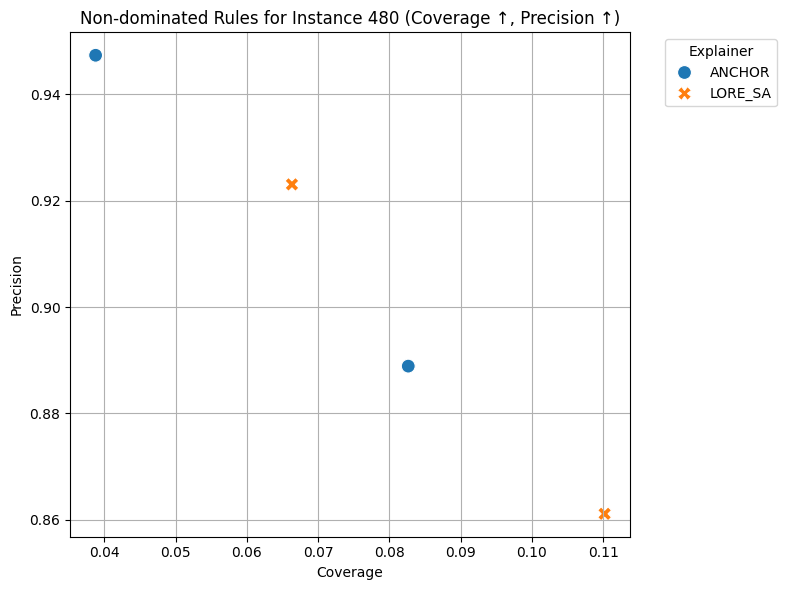

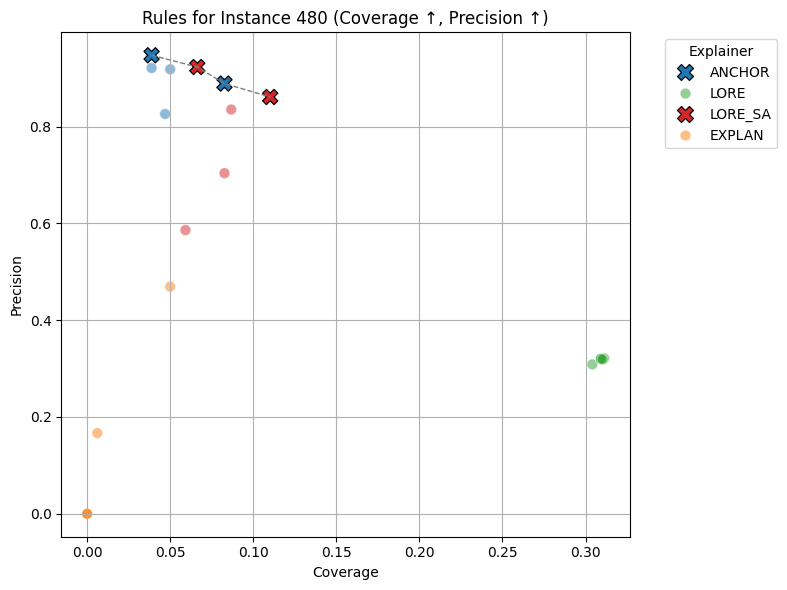

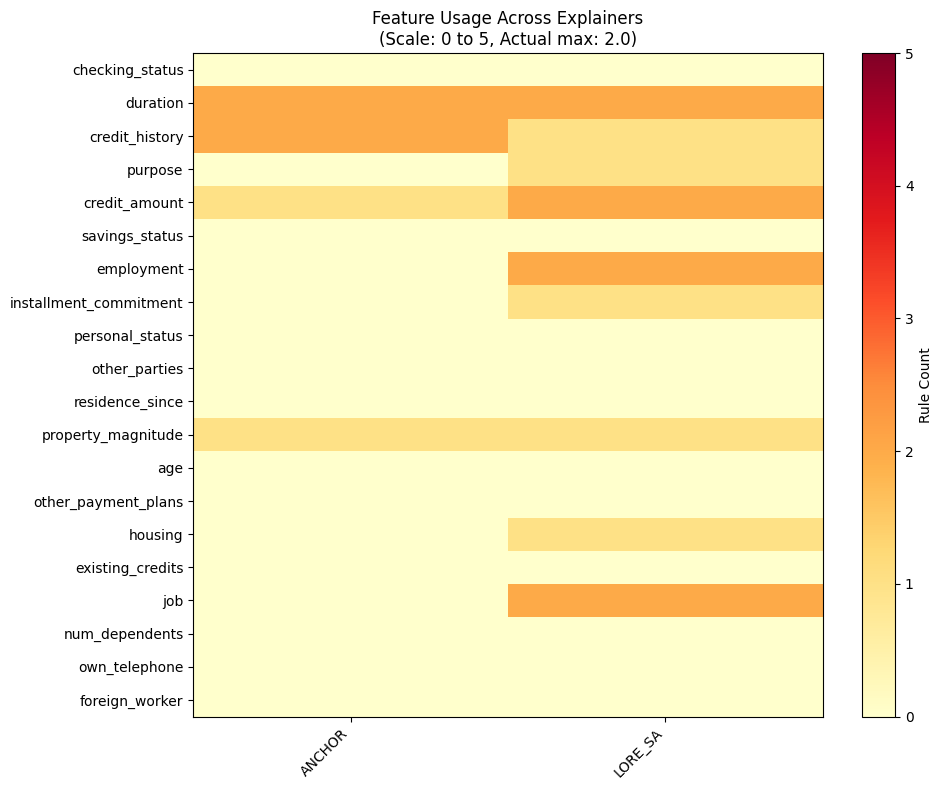

### Rules for Instance 480, Non-dominated (Cov_class↑, Pre↑, Len↓)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,480,ANCHOR,ANCHOR1,IF credit_history = critical/other existing credit AND duration <= 12.0 AND property_magnitude = real estate THEN class = good,0.03878,0.07347,0.94737,3,0,28.28518,False
1,480,ANCHOR,ANCHOR4,IF credit_amount <= 4109.58 AND credit_history = critical/other existing credit AND duration <= 12.0 THEN class = good,0.08265,0.14694,0.88889,3,0,32.39391,False
2,480,ANCHOR,ANCHOR5,IF credit_history = critical/other existing credit AND duration <= 12.0 AND installment_commitment <= 3.24 THEN class = good,0.05000,0.09184,0.91837,3,0,35.27383,False
3,480,LORE_SA,LORE_SA1,IF credit_amount <= 10961.72705078125 AND credit_history = critical/other existing credit AND duration <= 12.815183639526367 AND employment != less 1 year AND housing != for free AND job != high qualif/self emp/mgmt THEN class = good,0.06633,0.12245,0.92308,6,0,13.02728,False
4,480,LORE_SA,LORE_SA4,IF credit_amount <= 12629.076171875 AND duration <= 14.157926559448242 AND employment != less 1 year AND installment_commitment <= 3.726628541946411 AND job != high qualif/self emp/mgmt AND job != unemp/unskilled non res AND property_magnitude != no known property AND purpose != domestic appliance THEN class = good,0.11020,0.18980,0.86111,8,0,11.64874,False


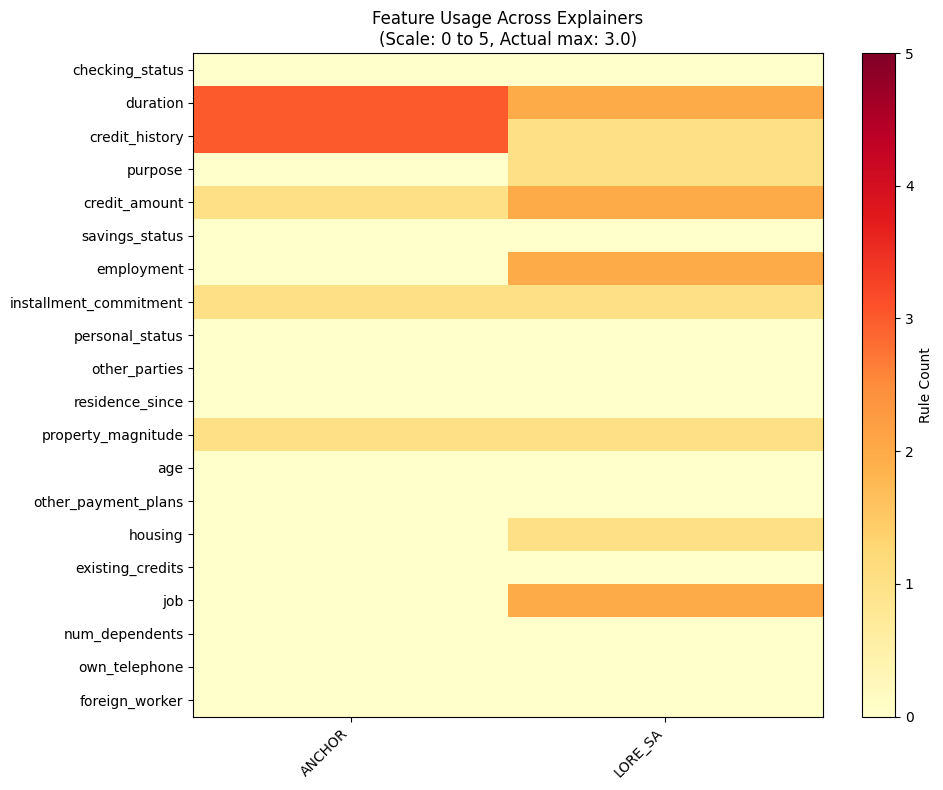

## Instance 11 (Original: bad , Predicted: bad)

,Value
checking_status,less 0
duration,48.0
credit_history,existing paid
purpose,business
credit_amount,4308.0
savings_status,less 100
employment,less 1 year
installment_commitment,3.0
personal_status,female div/dep/mar
other_parties,none


### Rules for Instance 11

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,11,ANCHOR,ANCHOR1,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.57634,False
1,11,ANCHOR,ANCHOR2,IF checking_status = less 0 AND duration > 12.0 AND foreign_worker = yes AND other_parties = none THEN class = bad,0.25918,0.44082,0.85039,4,3,18.35608,False
2,11,ANCHOR,ANCHOR3,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,7,41.64740,True
3,11,ANCHOR,ANCHOR4,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.40714,True
4,11,ANCHOR,ANCHOR5,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,4.53717,True
5,11,LORE,LORE1,IF checking_status = less 0 AND savings_status = less 100 THEN class = good,0.32449,0.14898,0.22956,2,0,69.80889,False
6,11,LORE,LORE2,IF checking_status = less 0 AND duration > 20.619233 AND foreign_worker = yes THEN class = good,0.18776,0.05918,0.15761,3,2,266.88453,False
7,11,LORE,LORE3,IF age > 23.732128 AND age <= 24.481663 AND checking_status = less 0 AND duration > 44.248552 AND housing = rent AND residence_since > 2.0 THEN class = bad,0.00102,0.00204,1.00000,6,0,63.78265,False
8,11,LORE,LORE4,IF checking_status = less 0 THEN class = good,0.37959,0.20408,0.26882,1,0,69.84798,False
9,11,LORE,LORE5,IF age <= 24.85795 AND duration > 44.248552 AND own_telephone = none AND property_magnitude = life insurance THEN class = bad,0.00102,0.00204,1.00000,4,3,290.58713,False


### Rules for Instance 11, Correct Prediction

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,11,ANCHOR,ANCHOR1,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.57634,False
1,11,ANCHOR,ANCHOR2,IF checking_status = less 0 AND duration > 12.0 AND foreign_worker = yes AND other_parties = none THEN class = bad,0.25918,0.44082,0.85039,4,3,18.35608,False
2,11,ANCHOR,ANCHOR3,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,7,41.64740,True
3,11,ANCHOR,ANCHOR4,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.40714,True
4,11,ANCHOR,ANCHOR5,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,4.53717,True
5,11,LORE,LORE3,IF age > 23.732128 AND age <= 24.481663 AND checking_status = less 0 AND duration > 44.248552 AND housing = rent AND residence_since > 2.0 THEN class = bad,0.00102,0.00204,1.00000,6,0,63.78265,False
6,11,LORE,LORE5,IF age <= 24.85795 AND duration > 44.248552 AND own_telephone = none AND property_magnitude = life insurance THEN class = bad,0.00102,0.00204,1.00000,4,3,290.58713,False
7,11,LORE_SA,LORE_SA1,IF checking_status = less 0 AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.31633,0.49796,0.78710,3,0,8.56845,False
8,11,LORE_SA,LORE_SA2,IF checking_status = less 0 AND credit_history != critical/other existing credit AND foreign_worker != no AND savings_status != greater 1000 AND savings_status != no known savings THEN class = bad,0.27857,0.45714,0.82051,5,0,8.39804,False
9,11,LORE_SA,LORE_SA3,IF checking_status = less 0 AND installment_commitment <= 3.6948803663253784 AND savings_status != greater 1000 AND savings_status = less 100 THEN class = bad,0.15306,0.22041,0.72000,4,0,7.92603,False


### Rules for Instance 11, Min_treshold (Cov 0.01, Cov_class 0.01, Pre 0.01)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,11,ANCHOR,ANCHOR1,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.57634,False
1,11,ANCHOR,ANCHOR2,IF checking_status = less 0 AND duration > 12.0 AND foreign_worker = yes AND other_parties = none THEN class = bad,0.25918,0.44082,0.85039,4,3,18.35608,False
2,11,ANCHOR,ANCHOR3,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,7,41.64740,True
3,11,ANCHOR,ANCHOR4,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.40714,True
4,11,ANCHOR,ANCHOR5,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,4.53717,True
5,11,LORE_SA,LORE_SA1,IF checking_status = less 0 AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.31633,0.49796,0.78710,3,0,8.56845,False
6,11,LORE_SA,LORE_SA2,IF checking_status = less 0 AND credit_history != critical/other existing credit AND foreign_worker != no AND savings_status != greater 1000 AND savings_status != no known savings THEN class = bad,0.27857,0.45714,0.82051,5,0,8.39804,False
7,11,LORE_SA,LORE_SA3,IF checking_status = less 0 AND installment_commitment <= 3.6948803663253784 AND savings_status != greater 1000 AND savings_status = less 100 THEN class = bad,0.15306,0.22041,0.72000,4,0,7.92603,False
8,11,LORE_SA,LORE_SA4,IF checking_status = less 0 AND employment != greater 7 years AND foreign_worker != no AND savings_status != greater 1000 THEN class = bad,0.27755,0.42857,0.77206,4,0,8.55756,False
9,11,LORE_SA,LORE_SA5,IF checking_status = less 0 AND other_parties != guarantor AND savings_status = less 100 THEN class = bad,0.31224,0.49388,0.79085,3,0,8.15198,False


### Rules for Instance 11, Non-dominated (Cov↑, Pre↑)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,11,ANCHOR,ANCHOR1,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.57634,False
1,11,ANCHOR,ANCHOR2,IF checking_status = less 0 AND duration > 12.0 AND foreign_worker = yes AND other_parties = none THEN class = bad,0.25918,0.44082,0.85039,4,3,18.35608,False
2,11,ANCHOR,ANCHOR3,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,7,41.64740,True
3,11,ANCHOR,ANCHOR4,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.40714,True
4,11,ANCHOR,ANCHOR5,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,4.53717,True
5,11,LORE_SA,LORE_SA1,IF checking_status = less 0 AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.31633,0.49796,0.78710,3,0,8.56845,False
6,11,LORE_SA,LORE_SA2,IF checking_status = less 0 AND credit_history != critical/other existing credit AND foreign_worker != no AND savings_status != greater 1000 AND savings_status != no known savings THEN class = bad,0.27857,0.45714,0.82051,5,0,8.39804,False
7,11,LORE_SA,LORE_SA5,IF checking_status = less 0 AND other_parties != guarantor AND savings_status = less 100 THEN class = bad,0.31224,0.49388,0.79085,3,0,8.15198,False


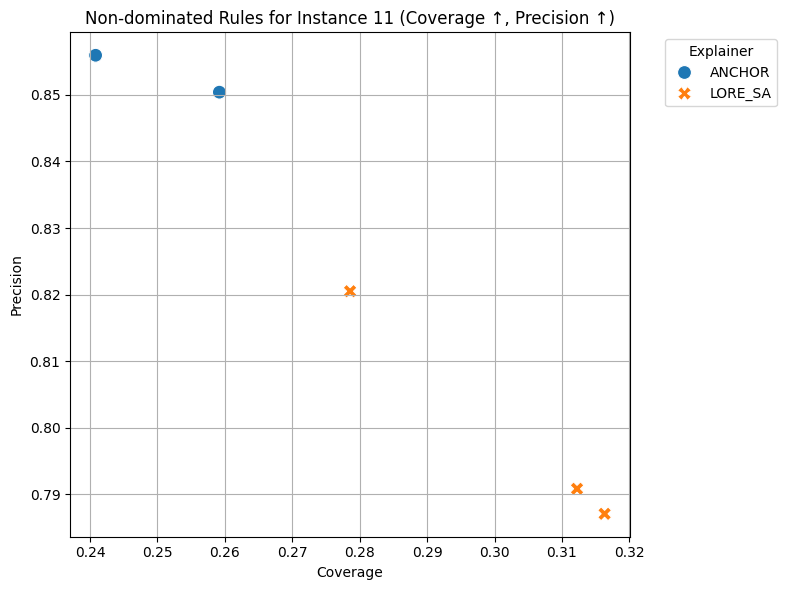

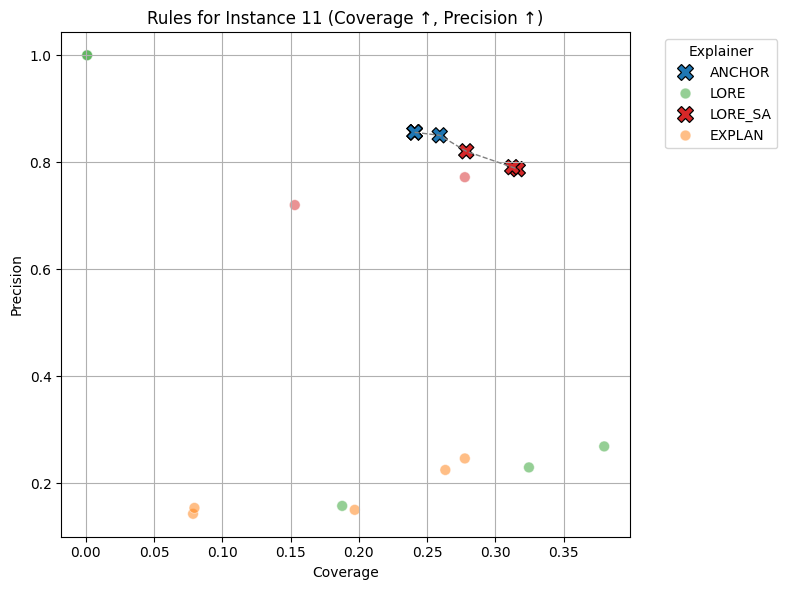

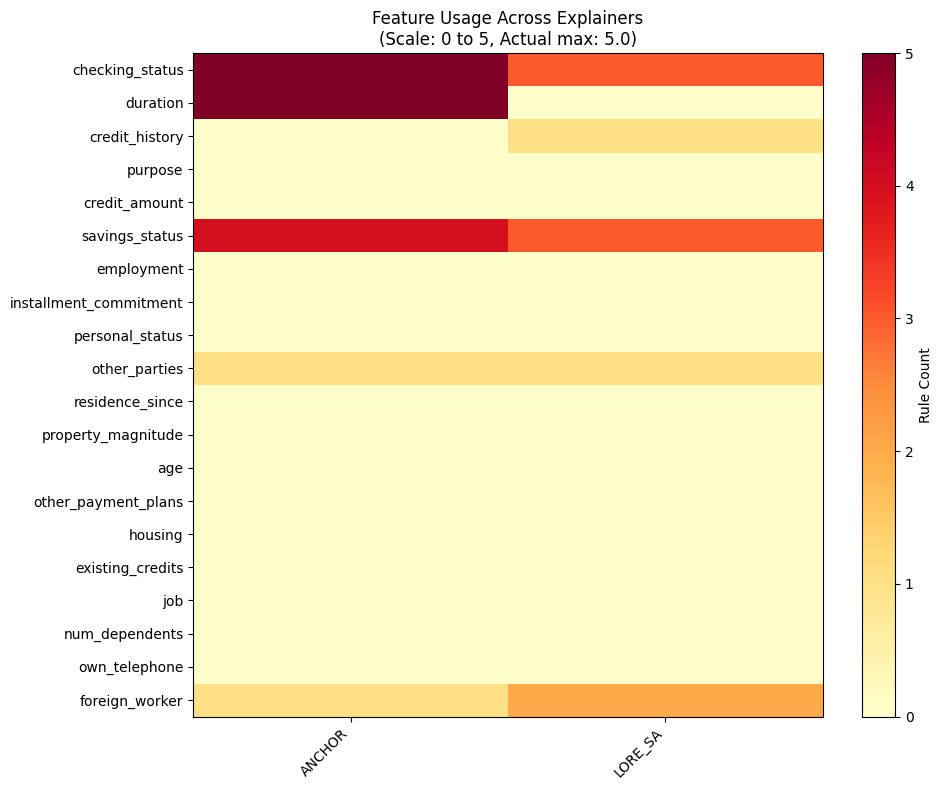

### Rules for Instance 11, Non-dominated (Cov_class↑, Pre↑, Len↓)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,11,ANCHOR,ANCHOR1,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.57634,False
1,11,ANCHOR,ANCHOR2,IF checking_status = less 0 AND duration > 12.0 AND foreign_worker = yes AND other_parties = none THEN class = bad,0.25918,0.44082,0.85039,4,3,18.35608,False
2,11,ANCHOR,ANCHOR3,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,7,41.64740,True
3,11,ANCHOR,ANCHOR4,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,5.40714,True
4,11,ANCHOR,ANCHOR5,IF checking_status = less 0 AND duration > 12.0 AND savings_status = less 100 THEN class = bad,0.24082,0.41224,0.85593,3,0,4.53717,True
5,11,LORE_SA,LORE_SA1,IF checking_status = less 0 AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.31633,0.49796,0.78710,3,0,8.56845,False
6,11,LORE_SA,LORE_SA2,IF checking_status = less 0 AND credit_history != critical/other existing credit AND foreign_worker != no AND savings_status != greater 1000 AND savings_status != no known savings THEN class = bad,0.27857,0.45714,0.82051,5,0,8.39804,False
7,11,LORE_SA,LORE_SA5,IF checking_status = less 0 AND other_parties != guarantor AND savings_status = less 100 THEN class = bad,0.31224,0.49388,0.79085,3,0,8.15198,False


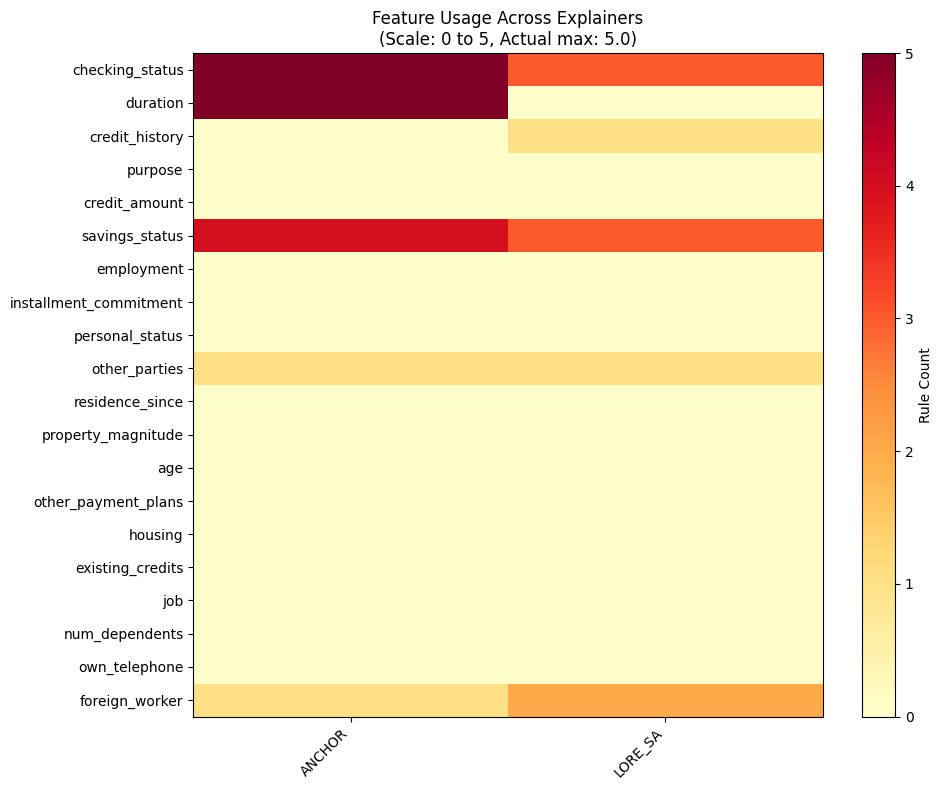

## Instance 917 (Original: bad , Predicted: bad)

,Value
checking_status,less 0
duration,6.0
credit_history,existing paid
purpose,new car
credit_amount,14896.0
savings_status,less 100
employment,greater 7 years
installment_commitment,1.0
personal_status,male single
other_parties,none


### Rules for Instance 917

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,917,ANCHOR,ANCHOR1,IF checking_status = less 0 AND credit_history = existing paid AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.22143,0.36531,0.82488,4,0,4.43100,False
1,917,ANCHOR,ANCHOR2,IF checking_status = less 0 AND installment_commitment <= 4.0 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.30000,0.48163,0.80272,4,0,3.92891,False
2,917,ANCHOR,ANCHOR3,IF checking_status = less 0 AND credit_amount > 1374.0 AND foreign_worker = yes AND other_parties = none AND savings_status = less 100 THEN class = bad,0.22347,0.37347,0.83562,5,0,3.77984,False
3,917,ANCHOR,ANCHOR4,IF checking_status = less 0 AND credit_history = existing paid AND other_parties = none THEN class = bad,0.24796,0.40816,0.82305,3,0,5.26595,False
4,917,ANCHOR,ANCHOR5,IF checking_status = less 0 AND credit_amount > 2319.5 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.14796,0.25306,0.85517,4,0,5.41831,False
5,917,LORE,LORE1,IF checking_status = less 0 AND credit_amount > 7656.124047 AND job = high qualif/self emp/mgmt AND num_dependents <= 2.0 AND personal_status = male single THEN class = good,0.00306,0.00204,0.33333,5,0,123.37174,False
6,917,LORE,LORE2,IF duration > 4.438708 AND duration <= 8.104739 AND other_payment_plans = bank AND own_telephone = yes THEN class = bad,0.00408,0.00000,0.00000,4,0,111.44420,False
7,917,LORE,LORE3,IF age > 47.0 AND duration > 5.730728 AND duration <= 6.0 AND other_payment_plans = bank THEN class = bad,0.00102,0.00000,0.00000,4,0,68.39624,False
8,917,LORE,LORE4,IF age > 59.0 AND duration <= 6.0 THEN class = bad,0.00408,0.00000,0.00000,2,0,162.26453,False
9,917,LORE,LORE5,IF age > 50.0 AND credit_history = existing paid AND duration <= 6.0 AND job = high qualif/self emp/mgmt AND num_dependents <= 1.0 AND other_payment_plans = bank AND own_telephone = yes THEN class = bad,0.00000,0.00000,0.00000,7,0,220.66470,False


### Rules for Instance 917, Correct Prediction

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,917,ANCHOR,ANCHOR1,IF checking_status = less 0 AND credit_history = existing paid AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.22143,0.36531,0.82488,4,0,4.43100,False
1,917,ANCHOR,ANCHOR2,IF checking_status = less 0 AND installment_commitment <= 4.0 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.30000,0.48163,0.80272,4,0,3.92891,False
2,917,ANCHOR,ANCHOR3,IF checking_status = less 0 AND credit_amount > 1374.0 AND foreign_worker = yes AND other_parties = none AND savings_status = less 100 THEN class = bad,0.22347,0.37347,0.83562,5,0,3.77984,False
3,917,ANCHOR,ANCHOR4,IF checking_status = less 0 AND credit_history = existing paid AND other_parties = none THEN class = bad,0.24796,0.40816,0.82305,3,0,5.26595,False
4,917,ANCHOR,ANCHOR5,IF checking_status = less 0 AND credit_amount > 2319.5 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.14796,0.25306,0.85517,4,0,5.41831,False
5,917,LORE,LORE2,IF duration > 4.438708 AND duration <= 8.104739 AND other_payment_plans = bank AND own_telephone = yes THEN class = bad,0.00408,0.00000,0.00000,4,0,111.44420,False
6,917,LORE,LORE3,IF age > 47.0 AND duration > 5.730728 AND duration <= 6.0 AND other_payment_plans = bank THEN class = bad,0.00102,0.00000,0.00000,4,0,68.39624,False
7,917,LORE,LORE4,IF age > 59.0 AND duration <= 6.0 THEN class = bad,0.00408,0.00000,0.00000,2,0,162.26453,False
8,917,LORE,LORE5,IF age > 50.0 AND credit_history = existing paid AND duration <= 6.0 AND job = high qualif/self emp/mgmt AND num_dependents <= 1.0 AND other_payment_plans = bank AND own_telephone = yes THEN class = bad,0.00000,0.00000,0.00000,7,0,220.66470,False
9,917,LORE_SA,LORE_SA1,IF checking_status = less 0 AND credit_amount > 12316.748046875 AND credit_history != delayed previously AND employment = greater 7 years AND foreign_worker = yes AND housing != for free AND housing = own AND job = high qualif/self emp/mgmt AND num_dependents <= 1.3137463927268982 AND other_parties = none AND personal_status = male single AND property_magnitude = no known property AND purpose != other AND savings_status = less 100 THEN class = bad,0.00000,0.00000,0.00000,14,0,7.74140,False


### Rules for Instance 917, Min_treshold (Cov 0.01, Cov_class 0.01, Pre 0.01)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,917,ANCHOR,ANCHOR1,IF checking_status = less 0 AND credit_history = existing paid AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.22143,0.36531,0.82488,4,0,4.43100,False
1,917,ANCHOR,ANCHOR2,IF checking_status = less 0 AND installment_commitment <= 4.0 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.30000,0.48163,0.80272,4,0,3.92891,False
2,917,ANCHOR,ANCHOR3,IF checking_status = less 0 AND credit_amount > 1374.0 AND foreign_worker = yes AND other_parties = none AND savings_status = less 100 THEN class = bad,0.22347,0.37347,0.83562,5,0,3.77984,False
3,917,ANCHOR,ANCHOR4,IF checking_status = less 0 AND credit_history = existing paid AND other_parties = none THEN class = bad,0.24796,0.40816,0.82305,3,0,5.26595,False
4,917,ANCHOR,ANCHOR5,IF checking_status = less 0 AND credit_amount > 2319.5 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.14796,0.25306,0.85517,4,0,5.41831,False


### Rules for Instance 917, Non-dominated (Cov↑, Pre↑)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,917,ANCHOR,ANCHOR2,IF checking_status = less 0 AND installment_commitment <= 4.0 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.30000,0.48163,0.80272,4,0,3.92891,False
1,917,ANCHOR,ANCHOR3,IF checking_status = less 0 AND credit_amount > 1374.0 AND foreign_worker = yes AND other_parties = none AND savings_status = less 100 THEN class = bad,0.22347,0.37347,0.83562,5,0,3.77984,False
2,917,ANCHOR,ANCHOR4,IF checking_status = less 0 AND credit_history = existing paid AND other_parties = none THEN class = bad,0.24796,0.40816,0.82305,3,0,5.26595,False
3,917,ANCHOR,ANCHOR5,IF checking_status = less 0 AND credit_amount > 2319.5 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.14796,0.25306,0.85517,4,0,5.41831,False


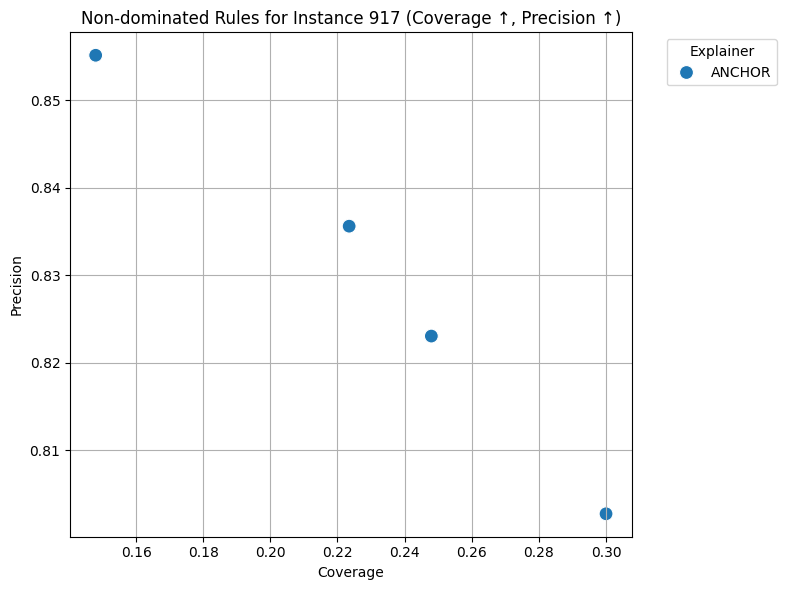

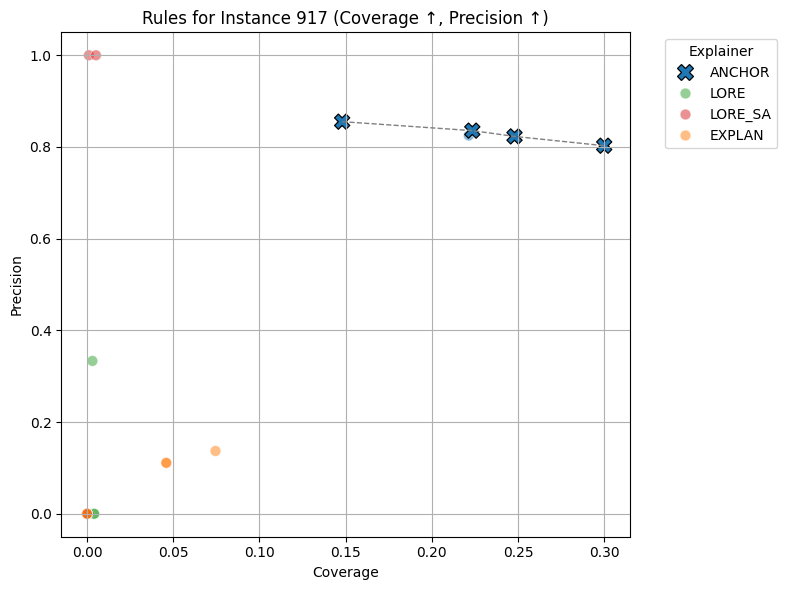

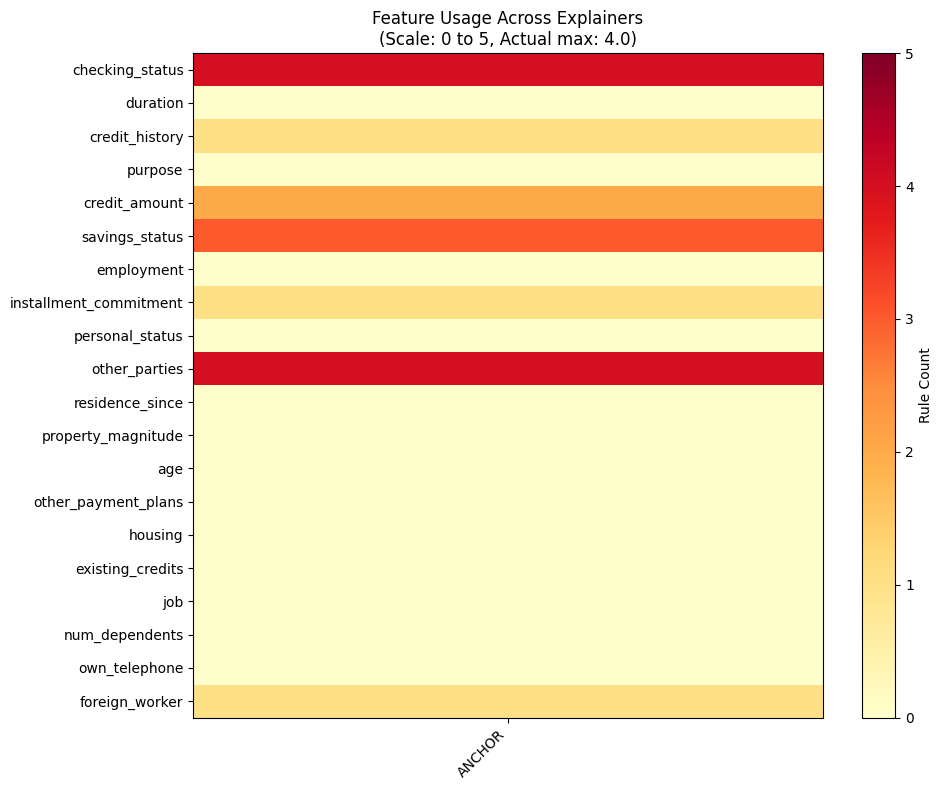

### Rules for Instance 917, Non-dominated (Cov_class↑, Pre↑, Len↓)

,Instance_Name,Explainer,Rule_ID,Rule,Cov,Cov_class,Pre,Len,Reject,Elapsed_time,Iter_Limit
0,917,ANCHOR,ANCHOR1,IF checking_status = less 0 AND credit_history = existing paid AND foreign_worker = yes AND savings_status = less 100 THEN class = bad,0.22143,0.36531,0.82488,4,0,4.43100,False
1,917,ANCHOR,ANCHOR2,IF checking_status = less 0 AND installment_commitment <= 4.0 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.30000,0.48163,0.80272,4,0,3.92891,False
2,917,ANCHOR,ANCHOR3,IF checking_status = less 0 AND credit_amount > 1374.0 AND foreign_worker = yes AND other_parties = none AND savings_status = less 100 THEN class = bad,0.22347,0.37347,0.83562,5,0,3.77984,False
3,917,ANCHOR,ANCHOR4,IF checking_status = less 0 AND credit_history = existing paid AND other_parties = none THEN class = bad,0.24796,0.40816,0.82305,3,0,5.26595,False
4,917,ANCHOR,ANCHOR5,IF checking_status = less 0 AND credit_amount > 2319.5 AND other_parties = none AND savings_status = less 100 THEN class = bad,0.14796,0.25306,0.85517,4,0,5.41831,False


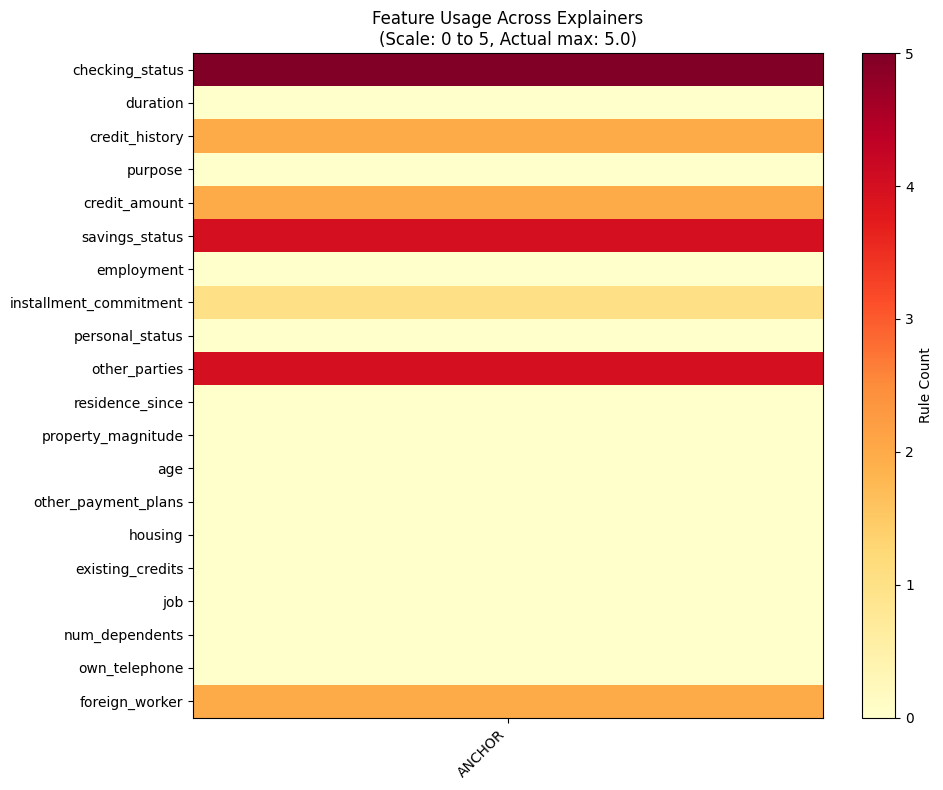

### Average Number of Filtered Rules at Each Step

,Avg Filtered (Correct Prediction),Avg Filtered (Threshold Filter),Avg Filtered (Non-dominated 1),Avg Filtered (Non-dominated 2)
Explainer,,,,
ANCHOR,0.00,0.00,1.250000,1.000000
EXPLAN,5.00,0.00,0.000000,0.000000
LORE,3.25,2.00,1.000000,1.000000
LORE_SA,0.00,1.25,2.666667,2.666667
Overall Average,8.25,2.75,3.500000,3.250000


### Average Metrics for Non-Dominated Rules (Cov↑, Pre↑)

,Pre,Cov,Cov_class,Len,Reject,Elapsed_time
ANCHOR,0.864289,0.200473,0.340713,2.987500,0.625000,14.315268
LORE_SA,0.861841,0.159977,0.265761,5.222222,0.000000,11.136034
Global_Average,0.863240,0.183117,0.308591,3.945238,0.357143,12.952740


### Average Metrics for Non-Dominated Rules (Cov_class↑, Pre↑, Len↓)

,Pre,Cov,Cov_class,Len,Reject,Elapsed_time
ANCHOR,0.864994,0.196821,0.334966,2.966667,0.666667,15.061163
LORE_SA,0.861841,0.159977,0.265761,5.222222,0.000000,11.136034
Global_Average,0.863643,0.181030,0.305306,3.933333,0.380952,13.378965


## Overall Heatmap – Non-dominated Rules (Cov↑, Pre↑)

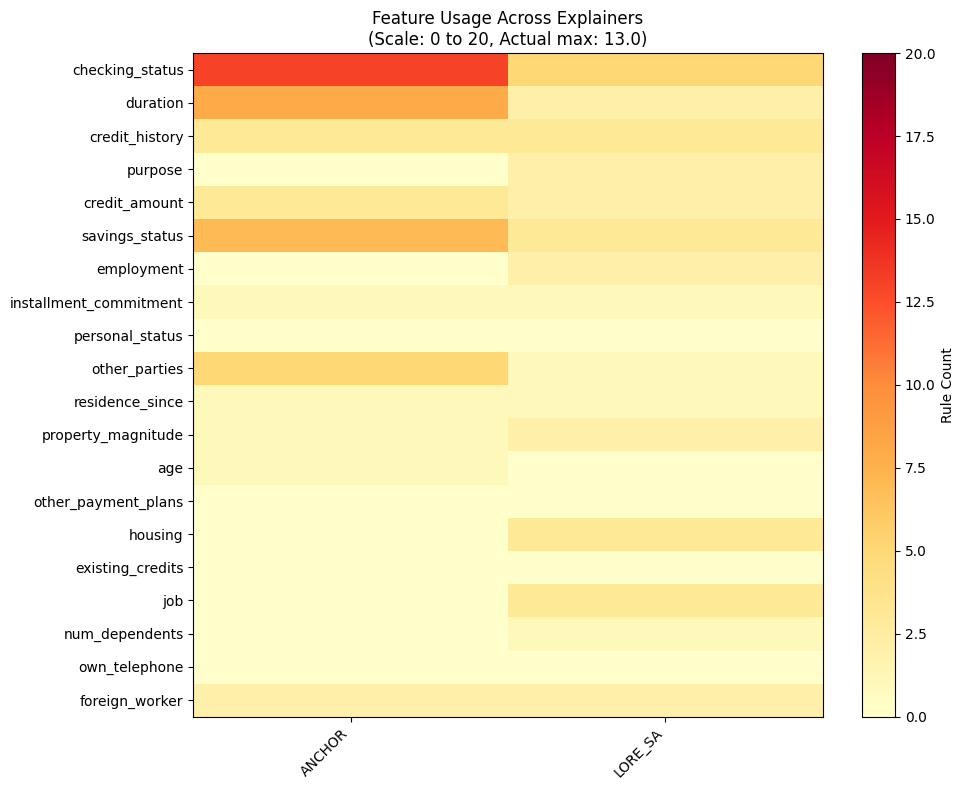

## Overall Heatmap – Non-dominated Rules (Cov_class↑, Pre↑, Len↓)

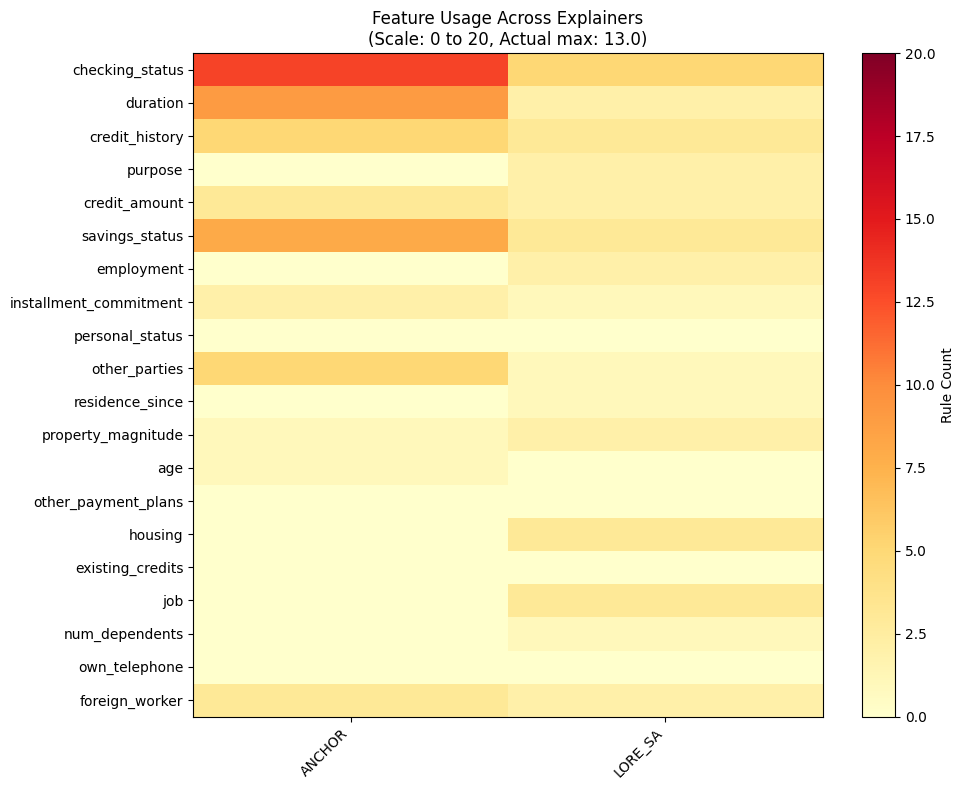

In [4]:
rules_log = "german_random_forest_rules_55-23_31-05-2025.txt"
entries_log = "german_random_forest_entries_55-23_31-05-2025.txt"
analyze_results(rules_log, entries_log, min_cov = 0.01, min_cov_class = 0.01, min_pre = 0.01)